In [300]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll
import mpl_toolkits.mplot3d.axes3d as p3
from scipy import stats

In [301]:
gpu_id = 0
device = torch.device('cuda:{}'.format(gpu_id)) if torch.cuda.is_available() else torch.device('cpu')

In [302]:
# Generate data (swiss roll dataset)
n_samples = 10000
noise = 0.05
y, modes = make_swiss_roll(n_samples, noise)

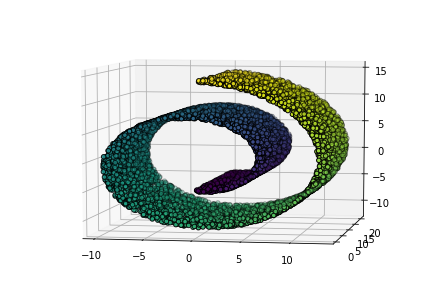

In [303]:
# Plot result
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(7, -80)
ax.scatter(y[:, 0], y[:, 1], y[:, 2], c=modes, s=20, edgecolor='k')
plt.show()

In [304]:
y = torch.from_numpy(y).float().to(device)

In [305]:
n_latent = 2  # size of the latent variable

n_epochs = 300
batch_size = 64  # samples of data distribution at each iteration
latent_batch_size = 2**15  # number of possible latent codes to try for each sample

In [306]:
# D_in is input dimension;
# H is hidden dimension;
# D_out is output dimension.

D_in, H, D_out = n_latent, 100, 3

model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
).to(device)

In [307]:
params = list(model.parameters())
    
optimizer = torch.optim.Adam(params, betas=(0.5, 0.999))
match_criterion_no_reduction = torch.nn.L1Loss(reduction='none')
criterion = torch.nn.L1Loss()

In [308]:
def sample_latent_codes(n_samples):
    return torch.empty(n_samples, n_latent, device=device).normal_()

In [309]:
def find_inverse(real_):
    
    # latent_batch_size x n_latent
    z = sample_latent_codes(latent_batch_size)
    
    # latent_batch_size x D_out
    fake_ = model(z)
    
    all_shape = [batch_size, latent_batch_size, D_out]
    
    # batch_size x latent_batch_size x D_out
    loss = match_criterion_no_reduction(fake_.unsqueeze(0).expand(all_shape),
                                        real_.unsqueeze(1).expand(all_shape))

    # batch_size x latent_batch_size
    loss = loss.mean(dim=2)

    # batch_size
    _, argmin = loss.min(dim=1)                     

    # z: latent_batch_size x n_latent
    # best_idx: batch_size x n_latent
    best_idx = argmin.unsqueeze(1).expand(batch_size, n_latent)

    # batch_size x n_latent
    best_z = torch.gather(z, 0, best_idx)

    # batch_size x n_latent
    best_z = best_z.squeeze(1)
    
    return best_z

In [310]:
loss_log = []

for epoch in range(1, n_epochs + 1):
    current_epoch_losses = []
    
    for t in range(n_samples // batch_size):
        rand_idx = np.random.randint(low=0, high=n_samples, size=batch_size)
        real = y[rand_idx]
        
        z_best = find_inverse(real)
        fake = model(z_best)

        loss = criterion(fake, real)

        # Zero the gradients before running the backward pass.
        optimizer.zero_grad()
        
        loss.backward()
        
        current_epoch_losses.append(loss)
        
        optimizer.step()
    
    loss_log.append(torch.tensor(current_epoch_losses).mean().detach().numpy())
    
    if True:  # if epoch % 10 == 0:
        print('Epoch: {} / Loss: {:.2f}'.format(epoch, loss_log[-1]))

Epoch: 1 / Loss: 2.63
Epoch: 2 / Loss: 1.75
Epoch: 3 / Loss: 1.14
Epoch: 4 / Loss: 0.96
Epoch: 5 / Loss: 0.81
Epoch: 6 / Loss: 0.75
Epoch: 7 / Loss: 0.70
Epoch: 8 / Loss: 0.66
Epoch: 9 / Loss: 0.64
Epoch: 10 / Loss: 0.56
Epoch: 11 / Loss: 0.45
Epoch: 12 / Loss: 0.41
Epoch: 13 / Loss: 0.34
Epoch: 14 / Loss: 0.29
Epoch: 15 / Loss: 0.27
Epoch: 16 / Loss: 0.27
Epoch: 17 / Loss: 0.24
Epoch: 18 / Loss: 0.23
Epoch: 19 / Loss: 0.24
Epoch: 20 / Loss: 0.20
Epoch: 21 / Loss: 0.19
Epoch: 22 / Loss: 0.19
Epoch: 23 / Loss: 0.18
Epoch: 24 / Loss: 0.17
Epoch: 25 / Loss: 0.18
Epoch: 26 / Loss: 0.18
Epoch: 27 / Loss: 0.16
Epoch: 28 / Loss: 0.16
Epoch: 29 / Loss: 0.16
Epoch: 30 / Loss: 0.16
Epoch: 31 / Loss: 0.15
Epoch: 32 / Loss: 0.15
Epoch: 33 / Loss: 0.15
Epoch: 34 / Loss: 0.15
Epoch: 35 / Loss: 0.14
Epoch: 36 / Loss: 0.15
Epoch: 37 / Loss: 0.14
Epoch: 38 / Loss: 0.15
Epoch: 39 / Loss: 0.14
Epoch: 40 / Loss: 0.14
Epoch: 41 / Loss: 0.14
Epoch: 42 / Loss: 0.14
Epoch: 43 / Loss: 0.14
Epoch: 44 / Loss: 0.

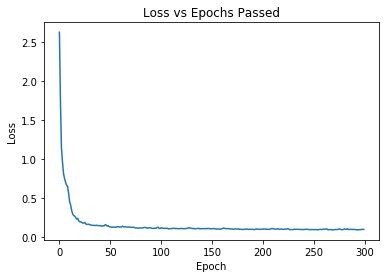

In [311]:
plt.figure()
plt.title('Loss vs Epochs Passed')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(len(loss_log)), loss_log)
plt.show()

In [316]:
all_c, all_z = [], []
for t in range(n_samples // batch_size):
    rand_idx = np.random.randint(low=0, high=n_samples, size=batch_size)
    real = y[rand_idx]
    c = torch.tensor(modes[rand_idx])
    z_best = find_inverse(real)
    
    all_c.append(c)
    all_z.append(z_best.clone())

In [317]:
z_ = torch.cat(all_z).cpu()
c_ = torch.cat(all_c)

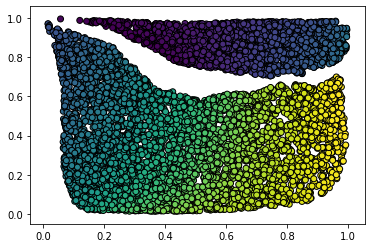

In [318]:
plt.figure()
plt.scatter(stats.norm.cdf(z_[:, 0]), 
            stats.norm.cdf(z_[:, 1]),
            c=c_, edgecolors='k')
plt.show()

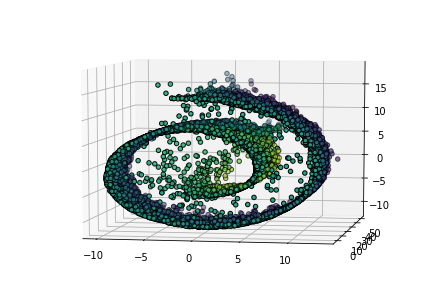

In [327]:
z_ = sample_latent_codes(n_samples)
y_ = model(z_).detach().cpu().numpy()

fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(7, -80)
ax.scatter(y_[:, 0], y_[:, 1], y_[:, 2], s=20, c=z_[:, 1].cpu(), edgecolor='k')
plt.show()